### Datafiniti's Hotel Reviews Sentiment Analysis

In this demo, I'll work on the Datafiniti Hotel Reviews dataset to build a sentiment analysis model using deep learning with a bag-of-words approach.

This dataset contains reviews with a title, a content and a rating. It also cointains information about the hotel and the reviewer, but I'll keep it simple by now and I'll only use the review title to predict the review rating. I'll then pass a title to this model to predict whether it's a good or a bad review.

In [1]:
import pandas as pd

hotels = pd.read_csv('data/Datafiniti_Hotel_Reviews.csv')
hotels = hotels.loc[:, ['reviews.rating', 'reviews.title']]
hotels.reset_index(inplace=True)
hotels['reviews.title'] = hotels['reviews.title'].apply(lambda x: str(x))
hotels.head()

,index,reviews.rating,reviews.title
0,0,5.0,Best romantic vacation ever!!!!
1,1,5.0,Sweet sweet serenity
2,2,5.0,Amazing Property and Experience
3,3,2.0,"Never again...beware, if you want sleep."
4,4,5.0,ALWAYS GREAT STAY...


#### Training and test sets

In [2]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(hotels)

#### Data preprocessing

We'll use keras `Tokenizer` class to perform some preprocessing on the text:

1. Lowercase
2. Remove puntuation
3. Tokenize
4. Transform text into index vectors

I'll use maximum 1000 words

In [3]:
from keras.preprocessing.text import Tokenizer

MAX_WORDS = 500
tokenizer = Tokenizer(num_words=MAX_WORDS)

X_train = train_set.loc[:, 'reviews.title'].values
y_train = train_set['reviews.rating']

X_test = test_set.loc[:, 'reviews.title'].values
y_test = test_set['reviews.rating']

tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_matrix(X_train)
X_test = tokenizer.texts_to_matrix(X_test)

X_train

Using TensorFlow backend.


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [7]:
import keras
from keras.layers import Dense, Dropout
from keras.models import Sequential


model = Sequential()

model.add(Dense(units=1024, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.2))
model.add(Dense(units=1024, activation='relu', input_dim=1024))
model.add(Dropout(0.2))
model.add(Dense(units=512, activation='relu', input_dim=1024))
model.add(Dropout(0.2))
model.add(Dense(units=1, input_dim=512))

model.compile(loss='mse',
              optimizer='adam', 
              metrics=['mae'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1024)              513024    
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 513       
Total para

#### Model training

As the data is not that big and I'll be using a GPU, I'll use the full data on each epoch. Also, I'll split use 20% of the data as validation set to monitor if there's overfitting.

In [8]:
history = model.fit(X_train, y_train, epochs=150, batch_size=len(X_train), verbose=2, validation_split=0.2)

Train on 6000 samples, validate on 1500 samples
Epoch 1/150
 - 4s - loss: 17.7528 - mean_squared_error: 17.7528 - mean_absolute_error: 4.0557 - val_loss: 13.6461 - val_mean_squared_error: 13.6461 - val_mean_absolute_error: 3.4829
Epoch 2/150
 - 2s - loss: 14.0450 - mean_squared_error: 14.0450 - mean_absolute_error: 3.5665 - val_loss: 8.7869 - val_mean_squared_error: 8.7869 - val_mean_absolute_error: 2.7227
Epoch 3/150
 - 2s - loss: 8.9397 - mean_squared_error: 8.9397 - mean_absolute_error: 2.7643 - val_loss: 4.4958 - val_mean_squared_error: 4.4958 - val_mean_absolute_error: 1.8517
Epoch 4/150
 - 2s - loss: 4.5482 - mean_squared_error: 4.5482 - mean_absolute_error: 1.8583 - val_loss: 3.6988 - val_mean_squared_error: 3.6988 - val_mean_absolute_error: 1.5207
Epoch 5/150
 - 2s - loss: 3.8112 - mean_squared_error: 3.8112 - mean_absolute_error: 1.5247 - val_loss: 6.4091 - val_mean_squared_error: 6.4091 - val_mean_absolute_error: 1.9508
Epoch 6/150
 - 2s - loss: 6.7131 - mean_squared_error: 6

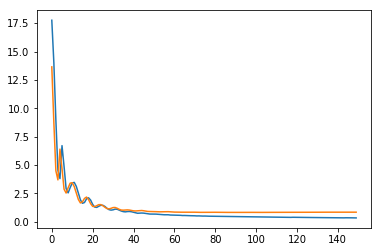

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

val_loss = history.history['val_loss']
loss = history.history['loss']

epochs = np.arange(len(loss))
up_to_epoch = 500

plt.plot(loss)
plt.plot(val_loss)
plt.show()

In [12]:
def predict_rating(text, model_):
    text_vector = tokenizer.texts_to_matrix([text])
    prediction = model_.predict(text_vector)
    
    return prediction[0, 0]

In [17]:
title = 'this hotel was a great experience in my life'
print(title, predict_rating(title, model))

title = 'awful experience'
print(title, predict_rating(title, model))

title = 'service was disappointing'
print(title, predict_rating(title, model))

title = 'totally recommended'
print(title, predict_rating(title, model))

this hotel was a great experience in my life 4.2517076
awful experience 2.3521416
service was disappointing 3.2309277
totally recommended 4.6322236


In [16]:
import pickle

model_json = model.to_json()

with open("data/datafiniti_hotel_reviews_sentiment.json", "w") as json_file:
    json_file.write(model_json)
    
model.save_weights("data/datafiniti_hotel_reviews_sentiment_weights.h5")

# saving
with open('data/datafiniti_hotel_reviews_sentiment_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)



#### Improvements

This model can improve if we apply some other techniques. To name some: 

- Word embeddings to preserve the words meaning
- Word stemming
- N-grams or even convolutional neural networks to preserve the meaning of consecutive words
- Recurrent neural networks to use the fact that sentences are sequences
